# Credit Card Fraud Detection

## Description

Wtih the massive acceleration of e-commerce, online payment fraud has surged, costing businesses over $20 billion annually worldwide. For every dollar lost to fraud, businesses incur additional operational costs, network fees, and customer churn. To combat this evolving and sophisticated threat, businesses need effective fraud detection solutions that leverage the power of data and machine learning (ML).

This project aims to develop an Ml-powered fraud detection model capable of identifying fraudulent transactions. Traiditonal approaches to fraud detection often rely on brute-force rules, which can be rigid and prone to blocking legitimate transactions (false positives). In contrast, ML-based models can identify nuanced patterns that help businesses maximize revenue by striking a balance between false positives (blocking good customers and false negatives (allowing fraud to pass).

### Dataset Overview
The dataset sourced from Kaggle presents a simulated credit card transaction dataset containing genuine and fraudulent transactions from Jan 1, 2019 - Dec 31, 20202. The dataset presents a realistic challenge due to its imbalanced nature, the majority of transactions being legitimate. The presence of numerous categorical features and a large number of variables requires careful feature selection to identify the most important predictors of fraud. Key considerations for this model include:
* Imbalanced dataset: As the majority of transactions are not fraudulent, techniques such as oversampling, undersampling, or SMOTE will be explored to balance the dataset.
* Feature selection: Given the high number of features, identifying the most important variables will be crucial to model performance and efficiency.
* Handling categorical variables: Appropriate encoding strategies (e.g. one-hot encoding or target encoding) will be applied to convert categorical  variables for the ML model.

### How to Choose a Performance Metric
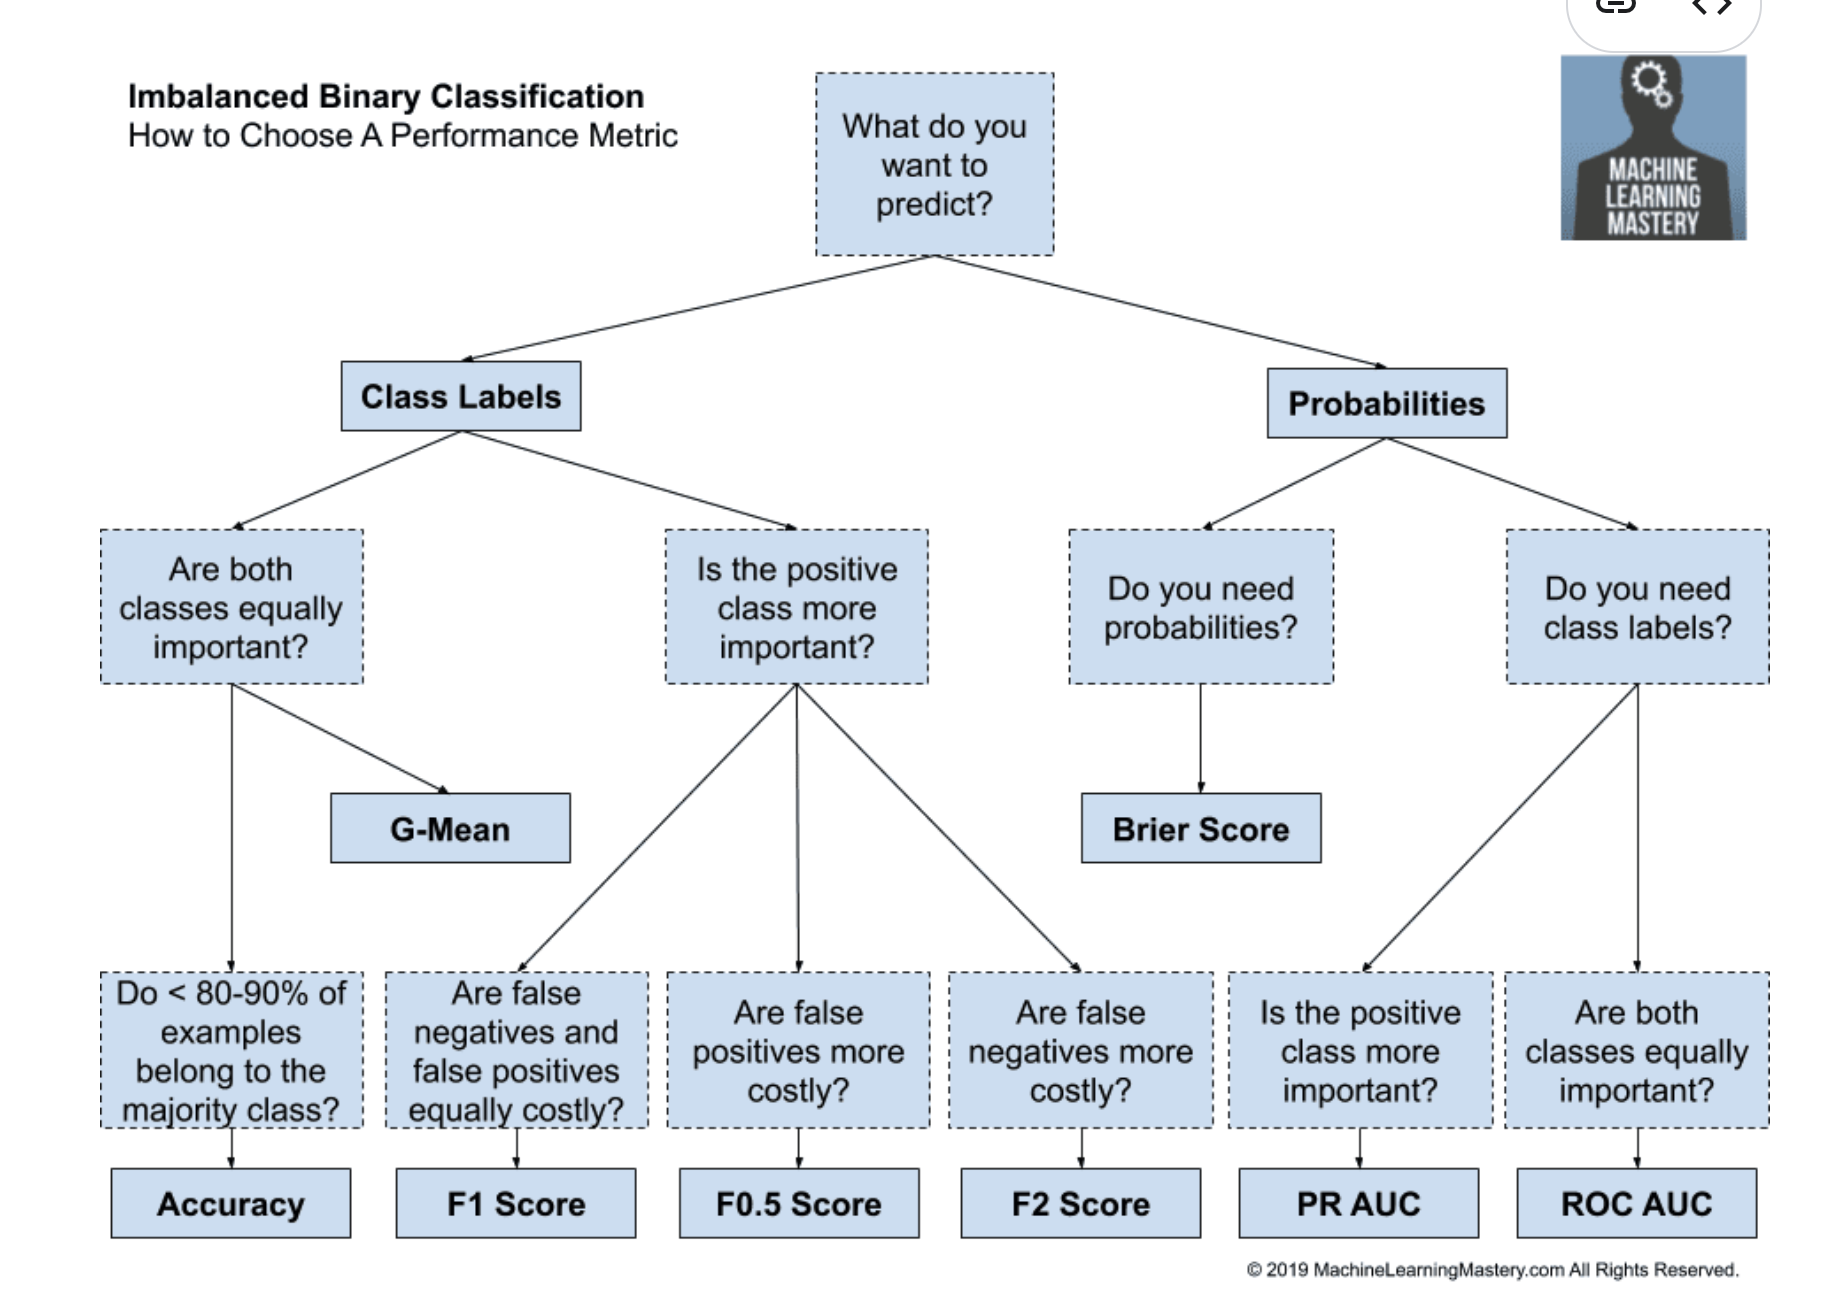

### Key Components of the Project
1. Data Preprocessing: Cleaning the dataset, balancing the classes, handling missing values, and encoding categorical features.
2. Feature Engineering: Identifying the most predictive features, reducing dimensionality, and optimizing model performance.
3. Model Development: Implementing a fraud detection model using techniques like logistic regression, decision trees, random forests, or gradient boosting, with a focus on improving precision and recall.
4. Model Evaluation: Evaluating model performance using metrics such as F1 score, precision, recall, and the ROC-AUC curve to understand the trade-offs between false positives and false negatives.

The goal is to build a robust, adaptive fraud detection model that helps businesses prevent fraud efficiently while minimizing disruption to legitimate customer transactions.

### Sources: 
* [Kaggle: Credit Card Transactions Fraud Detection Dataset](https://www.kaggle.com/datasets/kartik2112/fraud-detection/data)
* [Kaggle: Best techniques and metrics for Imbalanced Dataset](https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset)
* [Kaggle: Credit card Fraud Balance is Key](https://www.kaggle.com/code/ohseokkim/creditcard-fraud-balance-is-key-feat-pycaret)
* [Stripe: Risk Evaluation - Access the Stripe Radar risk evaluations in the Dashboard and the API](https://docs.stripe.com/radar/risk-evaluation)
* [Stripe: How Stripe uses ML for Fraud Detection](https://stripe.com/guides/primer-on-machine-learning-for-fraud-protection)
* [AWS: Banking Fraud Detection with Machine Learning and Real-time analytics on AWS](https://aws.amazon.com/blogs/industries/banking-fraud-detection-with-machine-learning-and-real-time-analytics-on-aws/)
* [Fine-tuned LLM on Fraud Detection](https://huggingface.co/Bilic/Mistral-7B-LLM-Fraud-Detection)
* [Evaluation Metrics for Imbalanced Classification](https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/)

### Credits:
Marcin Rutecki

In [5]:
pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Or install these packages individually
# !pip install folium
!pip install -U imblearn
# !pip install -U matplotlib
# !pip install numpy
# !pip install openai
# !pip install pandas
# !pip install plotly
!pip install --upgrade scikit-learn
# !pip install scipy
# !pip install seaborn
# !pip install streamlit
# !pip install watchdog
# !pip install xgboost

# Getting Started

In [5]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from pprint import pprint
from sklearn import metrics
from collections import Counter
from joblib import dump

import xgboost as xgb
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from pickle import dump

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Import data

[Kaggle Data Source for Fraud Detection](https://www.kaggle.com/datasets/kartik2112/fraud-detection/data)

## Utility functions

In [6]:
# Used for handling with large dataset files
def chunk_and_save(filename, chunksize=100000):
    prefix = filename.split('.')[0]

    # Read the large CSV in chunks
    chunk_iter = pd.read_csv(filename, chunksize=chunksize)

    # Split and save each chunk to a separate CSV file
    for i, chunk in enumerate(chunk_iter):
        chunk.to_csv(f'{prefix}_{i+1}.csv', index=False)
        print(f'{prefix}_{i+1}.csv created with {len(chunk)} rows')

# Used for importing files from Google Drive
def create_df_from_paths(paths):
    processed_paths = ['https://drive.google.com/uc?id=' + path.split('/')[-2] for path in paths]
    df_list = [pd.read_csv(path) for path in processed_paths]

    # Concatenate all DataFrames into one
    df = pd.concat(df_list, ignore_index=True)

    # Reset the index and drop the 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])

    # Resetting the index
    df = df.reset_index(drop=True)

    return df.copy()

def preprocess_df(df):
    # Drop Null rows
    df = df.dropna()

    # Drop duplicated values
    df.drop_duplicates(inplace=True)

    return df.copy()

def add_features(df, median_price):
    # Convert columns to datetime
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['dob'] = pd.to_datetime(df['dob'])

    # Extract the year from 'trans_date_trans_time' and 'dob'
    df['trans_year'] = df['trans_date_trans_time'].dt.year
    df['dob_year'] = df['dob'].dt.year

    # Calculate age
    df['age'] = df['trans_year'] - df['dob_year']

    # Reset index
    df = df.reset_index(drop=True)

    # Add age group features
    bins = [0, 32, 47, 75, 100]
    labels = ['Early', 'MiddleAge', 'Senior', 'Elderly']

    df['ageGroup'] = pd.cut(df['age'], bins=bins, labels=labels)

    # Create a new column 'price_ratio_to_median'
    df['price_ratio_to_median'] = df['amt'] / median_price

    return df.copy()

def encode_categories(df1, df2, categorical_cols):
    """
    Consolidates unique categories across two dataframes for specified categorical columns and
    applies consistent categorical encoding across both dataframes.

    Parameters:
    - df1: First dataframe
    - df2: Second dataframe
    - categorical_cols: List of column names to be processed as categorical

    Returns:
    - category_mappings: Dictionary of mappings for each column
    - df1 and df2 with new columns containing encoded categorical codes
    """

    # Convert specified columns to 'category' dtype
    for col in categorical_cols:
        df1[col] = df1[col].astype('category')
        df2[col] = df2[col].astype('category')

    category_mappings = {}

    # Loop through each categorical column
    for col in categorical_cols:
        # Consolidate unique categories across both dataframes
        unique_categories = pd.Index(df1[col].cat.categories).union(df2[col].cat.categories)

        # Set consolidated categories for each dataframe to align codes
        df1[col] = df1[col].cat.set_categories(unique_categories)
        df2[col] = df2[col].cat.set_categories(unique_categories)

        # Store mapping and apply categorical codes
        mapping = dict(enumerate(unique_categories))
        category_mappings[col] = mapping

        # Create encoded columns in each dataframe
        df1[f'{col}_codes'] = df1[col].cat.codes
        df2[f'{col}_codes'] = df2[col].cat.codes

    # Display the consolidated mappings
    pprint(category_mappings)
    return category_mappings, df1, df2


def evaluate_and_save_model(model, X_train, X_test, y_train, y_test, dir='model_fraud', suffix=""):
    start_time = time.time()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Print the accuracy rate of the model
    accuracy = accuracy_score(y_test, y_pred)
    modelName = model.__class__.__name__ 
    print(f"{modelName} Accuracy: {accuracy:.4f}")
    
    # Display confusion matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

    # Print classification report with zero_division=1 to avoid warnings
    report = classification_report(y_test, y_pred, zero_division=1)
    print(f"\nClassification Report:\n{report}")

    # Create the save directory if it does not exist
    os.makedirs(dir, exist_ok=True)

    # Set full path for the model file
    filename = os.path.join(dir, modelName + suffix + '.pkl')
    with open(filename, "wb") as file:
        dump(model, file)
        
    print(f"Model saved as {filename}")
    
    # Calculate the total time taken
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Time taken for execution: {elapsed_time:.2f} seconds")
    
    divider = "-"* 50 + "\n"
    print(divider)

In [7]:
# Uncomment to convert large file into smaller .csv files

# filename = 'fraudTrain.csv'
# chunk_and_save(filename)

# filename = 'fraudTest.csv'
# chunk_and_save(filename)

In [8]:
train_paths = [
    "https://drive.google.com/file/d/11Kj0MN-7IOSlCJf70CynkjrfNeg0T2YA/view?usp=sharing",
    "https://drive.google.com/file/d/1tx98tuEhkYZS2U8xad9bl2IswhNR2a6a/view?usp=sharing",
    "https://drive.google.com/file/d/16QjJYQD41t75F3S5ak4m-Ud3z1PoE62k/view?usp=sharing",
    "https://drive.google.com/file/d/1QJxTBTYI0MEVjHSsMWS29ME2i74MUJaG/view?usp=sharing",
    "https://drive.google.com/file/d/1nK2TB84DznqokMAd7dY-bJJjiu4QxxXn/view?usp=sharing",
    "https://drive.google.com/file/d/1i7NQdaQ8s-F2xF_hR4hFCzfWJC5vLiQJ/view?usp=sharing",
    "https://drive.google.com/file/d/1h_vK5XqE3CqADW0X2zKhJys802Sy6Y9H/view?usp=sharing",
    "https://drive.google.com/file/d/1Qs456rUFC5BPyQFJFmAzkOIBKebwrV4g/view?usp=sharing",
    "https://drive.google.com/file/d/1slFK0jJ37p2Y2Bi3beFIaXGWULSua93_/view?usp=sharing",
    "https://drive.google.com/file/d/16kwgNLYvK8ohhWTkO1eONiJ2qX1R8Fij/view?usp=sharing",
    "https://drive.google.com/file/d/1kUUPFkZh2eo1OXq671PLSJ_8FwbWWBwh/view?usp=sharing",
    "https://drive.google.com/file/d/1nLPw3z1zXxeHhSjRHA51fNw0_IlczUKT/view?usp=sharing",
    "https://drive.google.com/file/d/1eOmGBVG17TmRtuM9Gx7m3Btxcg_h5bJo/view?usp=sharing"
]

raw_df = create_df_from_paths(train_paths)

test_paths = [
    "https://drive.google.com/file/d/1AhYQ27vN7e0FZvva1RtE6y0UNXCQkOB8/view?usp=sharing",
    "https://drive.google.com/file/d/1fSvWjRgPAdsvFNATupUnyF_3XFdQaGHK/view?usp=sharing",
    "https://drive.google.com/file/d/10Rywm6hGRja3sVKPCJ0GhKuHMVIUHc4D/view?usp=sharing",
    "https://drive.google.com/file/d/1dOm2-yT3e6uYUynSRJqF4Q0h-Hrnu0zX/view?usp=sharing",
    "https://drive.google.com/file/d/18-Jee5xwimtzh4G2rMmzGQX3bze4uO_Z/view?usp=sharing",
    "https://drive.google.com/file/d/1dsZXqOsHoMp56tfHcTSq66Lpx2ybKG2z/view?usp=sharing"
]

test_raw_df = create_df_from_paths(test_paths)

raw_df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,...,37.7175,-112.4777,258,Geoscientist,1961-11-24,440b587732da4dc1a6395aba5fb41669,1371816728,36.841266,-111.690765,0
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,...,39.2667,-77.5101,100,"Production assistant, television",1979-12-11,278000d2e0d2277d1de2f890067dcc0a,1371816739,38.906881,-78.246528,0
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,...,32.9396,-105.8189,899,Naval architect,1967-08-30,483f52fe67fabef353d552c1e662974c,1371816752,33.619513,-105.130529,0
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,...,43.3526,-102.5411,1126,Volunteer coordinator,1980-08-18,d667cdcbadaaed3da3f4020e83591c83,1371816816,42.788940,-103.241160,0


In [9]:
raw_df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


## Preprocess data
* Remove rows with null values
* Drop duplicates

In [10]:
processed_df = preprocess_df(raw_df)
test_processed_df = preprocess_df(test_raw_df)

## Add Features

In [11]:
median_price = processed_df['amt'].median()
processed_df = add_features(processed_df, median_price)
test_processed_df = add_features(test_processed_df, median_price)

## Create Categorical Mappings

In [12]:
cat_cols = ['category', 'state', 'ageGroup', 'gender']
mappings, processed_df, test_processed_df = encode_categories(processed_df, test_processed_df, cat_cols)

{'ageGroup': {0: 'Early', 1: 'MiddleAge', 2: 'Senior', 3: 'Elderly'},
 'category': {0: 'entertainment',
              1: 'food_dining',
              2: 'gas_transport',
              3: 'grocery_net',
              4: 'grocery_pos',
              5: 'health_fitness',
              6: 'home',
              7: 'kids_pets',
              8: 'misc_net',
              9: 'misc_pos',
              10: 'personal_care',
              11: 'shopping_net',
              12: 'shopping_pos',
              13: 'travel'},
 'gender': {0: 'F', 1: 'M'},
 'state': {0: 'AK',
           1: 'AL',
           2: 'AR',
           3: 'AZ',
           4: 'CA',
           5: 'CO',
           6: 'CT',
           7: 'DC',
           8: 'DE',
           9: 'FL',
           10: 'GA',
           11: 'HI',
           12: 'IA',
           13: 'ID',
           14: 'IL',
           15: 'IN',
           16: 'KS',
           17: 'KY',
           18: 'LA',
           19: 'MA',
           20: 'MD',
           21: 'ME',
     

## Data Imbalance Check

In [13]:
sns.set_style(style='whitegrid')
plt.figure(figsize=(12, 10))

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

In [14]:
labels=["Genuine","Fraud"]

fraud_or_not = processed_df["is_fraud"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]
total = sum(values)
fraud_percent = fraud_or_not[0] / total * 100
non_fraud_percent = fraud_or_not[1] / total * 100
print(f"Total: {total}")
print(f"Non-fraudulent Transactions: {values[0]} or {fraud_percent: .2f}% of the dataset")
print(f"Fraudulent Transactions: {values[1]} or {non_fraud_percent: .2f}% of the dataset")


Total: 1296675
Non-fraudulent Transactions: 1289169 or  99.42% of the dataset
Fraudulent Transactions: 7506 or  0.58% of the dataset


In [15]:
fig = px.pie(values=raw_df["is_fraud"].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Genuine transactions")
fig.show()

This pie chart below highlights the significant imbalance in our dataset, with the vast majority of transactions being non-fraudulent. Specifically, 

* 99.42% (1289169 / 1296675) of the data represents non-fraudulent transactions

* 0.58% (7506 / 1296675) are labeled as fraudulent.


This imbalance poses a challenge for model evaluation, as using accuracy as a performance metric could be misleading—yielding high accuracy simply due to the prevalence of non-fraudulent transactions. To ensure a more realistic assessment, we should consider alternative metrics like precision, recall, or F1-score, which better account for the minority class.

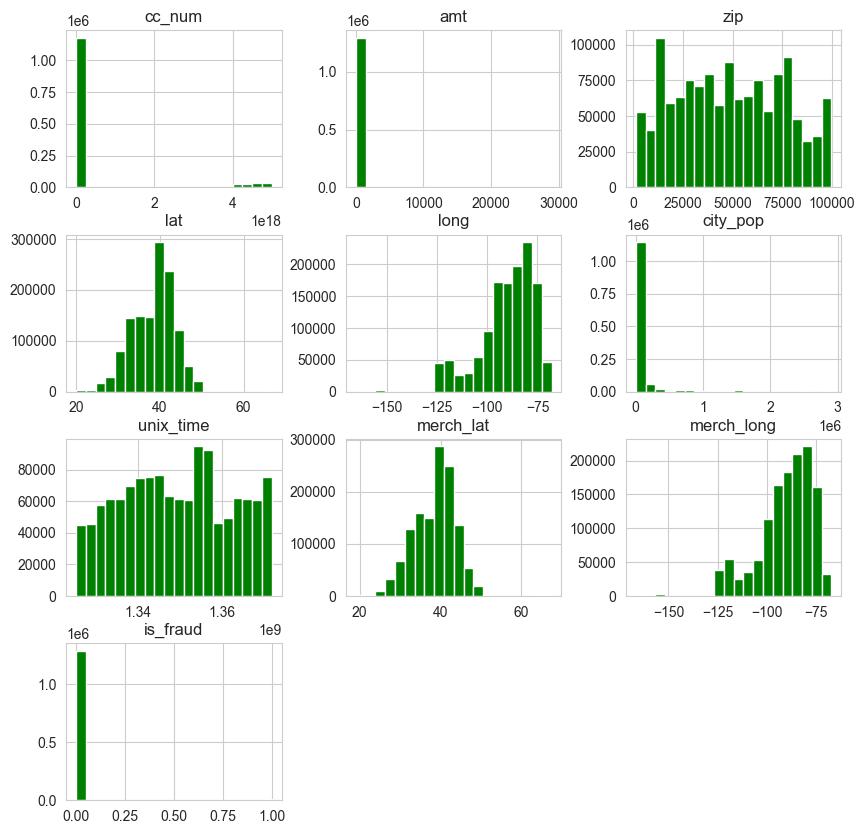

In [16]:
raw_df.hist(bins = 20, figsize = (10,10), color = 'g');

In [17]:
# import folium

# # Create a base map centered at the mean of latitude and longitude
# map_fraud = folium.Map(location=[train_df['lat'].mean(), train_df['long'].mean()], zoom_start=1)

# # Iterate through the DataFrame to add markers with different colors
# for index, row in train_df.iterrows():
#     # Set the marker color based on 'is_fraud' column
#     marker_color = 'red' if row['is_fraud'] == 1 else 'blue'
    
#     # Add a marker to the map
#     folium.Marker(
#         location=[row['lat'], row['long']],
#         popup=f"customer: {row['first']}, Fraud: {row['is_fraud']}",
#         icon=folium.Icon(color=marker_color)
#     ).add_to(map_fraud)

# # Display the map
# map_fraud

Text(0.5, 1.0, 'Amount Distribution by Fraud')

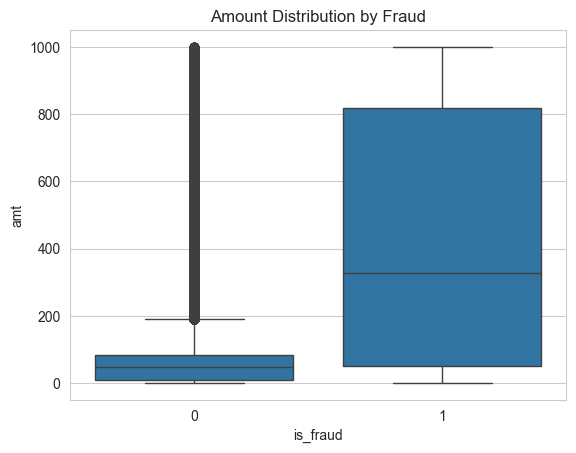

In [18]:
amount_df = processed_df.query('amt < 1000')

sns.boxplot(x='is_fraud', y='amt', data=amount_df)
plt.title('Amount Distribution by Fraud')


In [19]:
columns = list(processed_df.columns)
columns

['trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud',
 'trans_year',
 'dob_year',
 'age',
 'ageGroup',
 'price_ratio_to_median',
 'category_codes',
 'state_codes',
 'ageGroup_codes',
 'gender_codes']

## Display unique values in the all fraud dataset

In [20]:
uniq_values = processed_df.nunique()
uniq_values

trans_date_trans_time    1274791
cc_num                       983
merchant                     693
category                      14
amt                        52928
first                        352
last                         481
gender                         2
street                       983
city                         894
state                         51
zip                          970
lat                          968
long                         969
city_pop                     879
job                          494
dob                          968
trans_num                1296675
unix_time                1274823
merch_lat                1247805
merch_long               1275745
is_fraud                       2
trans_year                     2
dob_year                      81
age                           83
ageGroup                       4
price_ratio_to_median      52928
category_codes                14
state_codes                   51
ageGroup_codes                 4
gender_cod

In [21]:
fraud_df = processed_df.query('is_fraud == 1')
fraud_df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,is_fraud,trans_year,dob_year,age,ageGroup,price_ratio_to_median,category_codes,state_codes,ageGroup_codes,gender_codes
2449,2019-01-02 01:06:37,4613314721966,fraud_Rutherford-Mertz,grocery_pos,281.06,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,...,1,2019,1988,31,Early,5.914562,4,27,0,1
2472,2019-01-02 01:47:29,340187018810220,"fraud_Jenkins, Hauck and Friesen",gas_transport,11.52,Misty,Hart,F,27954 Hall Mill Suite 575,San Antonio,...,1,2019,1960,59,Senior,0.242424,2,43,2,0
2523,2019-01-02 03:05:23,340187018810220,fraud_Goodwin-Nitzsche,grocery_pos,276.31,Misty,Hart,F,27954 Hall Mill Suite 575,San Antonio,...,1,2019,1960,59,Senior,5.814604,4,43,2,0
2546,2019-01-02 03:38:03,4613314721966,fraud_Erdman-Kertzmann,gas_transport,7.03,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,...,1,2019,1988,31,Early,0.147938,2,27,0,1
2553,2019-01-02 03:55:47,340187018810220,fraud_Koepp-Parker,grocery_pos,275.73,Misty,Hart,F,27954 Hall Mill Suite 575,San Antonio,...,1,2019,1960,59,Senior,5.802399,4,43,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1295399,2020-06-21 01:00:08,3524574586339330,fraud_Kassulke PLC,shopping_net,977.01,Ashley,Cabrera,F,94225 Smith Springs Apt. 617,Vero Beach,...,1,2020,1986,34,MiddleAge,20.559975,11,9,1,0
1295491,2020-06-21 01:53:35,3524574586339330,fraud_Schumm PLC,shopping_net,1210.91,Ashley,Cabrera,F,94225 Smith Springs Apt. 617,Vero Beach,...,1,2020,1986,34,MiddleAge,25.482113,11,9,1,0
1295532,2020-06-21 02:16:56,4005676619255478,"fraud_Tillman, Dickinson and Labadie",gas_transport,10.24,William,Perry,M,458 Phillips Island Apt. 768,Denham Springs,...,1,2020,1994,26,Early,0.215488,2,18,0,1
1295666,2020-06-21 03:26:20,3560725013359375,fraud_Corwin-Collins,gas_transport,21.69,Brooke,Smith,F,63542 Luna Brook Apt. 012,Notrees,...,1,2020,1969,51,Senior,0.456439,2,43,2,0


In [22]:
# Calculate unique category counts
states_counts = fraud_df['state'].value_counts().reset_index()
states_counts

,state,count
0,NY,555
1,TX,479
2,PA,458
3,CA,326
4,OH,321
5,FL,281
6,IL,248
7,MI,238
8,AL,215
9,MN,207


In [23]:
# Calculate unique job counts
job_counts = fraud_df['job'].value_counts().reset_index()
job_counts

,job,count
0,Materials engineer,62
1,Trading standards officer,56
2,Naval architect,53
3,Exhibition designer,51
4,"Surveyor, land/geomatics",50
...,...,...
438,Statistician,3
439,Health physicist,3
440,Chartered loss adjuster,3
441,English as a second language teacher,2


In [24]:
# Calculate unique city counts
city_counts = fraud_df['city'].value_counts().reset_index()
city_counts

,city,count
0,Houston,39
1,Warren,33
2,Huntsville,29
3,Naples,29
4,Dallas,27
...,...,...
697,Florence,3
698,Kilgore,2
699,Phoenix,2
700,Phenix City,2


In [25]:
# Calculate unique zip counts
zip_counts = fraud_df['zip'].value_counts().reset_index()
zip_counts

,zip,count
0,15010,24
1,48088,23
2,16034,21
3,82514,21
4,68375,19
...,...,...
749,33811,2
750,36869,2
751,85020,2
752,28405,2


In [26]:
# Calculate unique category counts
category_counts = fraud_df['category'].value_counts().reset_index()
category_counts

,category,count
0,grocery_pos,1743
1,shopping_net,1713
2,misc_net,915
3,shopping_pos,843
4,gas_transport,618
5,misc_pos,250
6,kids_pets,239
7,entertainment,233
8,personal_care,220
9,home,198


In [27]:
# Calculate unique job counts
job_counts = fraud_df['job'].value_counts().reset_index()
job_counts

,job,count
0,Materials engineer,62
1,Trading standards officer,56
2,Naval architect,53
3,Exhibition designer,51
4,"Surveyor, land/geomatics",50
...,...,...
438,Statistician,3
439,Health physicist,3
440,Chartered loss adjuster,3
441,English as a second language teacher,2


In [28]:
# Calculate unique merchant counts
merchant_counts = fraud_df['merchant'].value_counts().reset_index()
merchant_counts

,merchant,count
0,fraud_Rau and Sons,49
1,fraud_Cormier LLC,48
2,fraud_Kozey-Boehm,48
3,fraud_Doyle Ltd,47
4,fraud_Vandervort-Funk,47
...,...,...
674,fraud_Kuphal-Toy,1
675,fraud_Eichmann-Kilback,1
676,fraud_Lynch-Mohr,1
677,fraud_Tillman LLC,1


# !!!!!! TODO: DELETE OUTLIERS (OR NOT)

In [29]:
columns

['trans_date_trans_time',
 'cc_num',
 'merchant',
 'category',
 'amt',
 'first',
 'last',
 'gender',
 'street',
 'city',
 'state',
 'zip',
 'lat',
 'long',
 'city_pop',
 'job',
 'dob',
 'trans_num',
 'unix_time',
 'merch_lat',
 'merch_long',
 'is_fraud',
 'trans_year',
 'dob_year',
 'age',
 'ageGroup',
 'price_ratio_to_median',
 'category_codes',
 'state_codes',
 'ageGroup_codes',
 'gender_codes']

In [30]:
boxplot_columns = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']

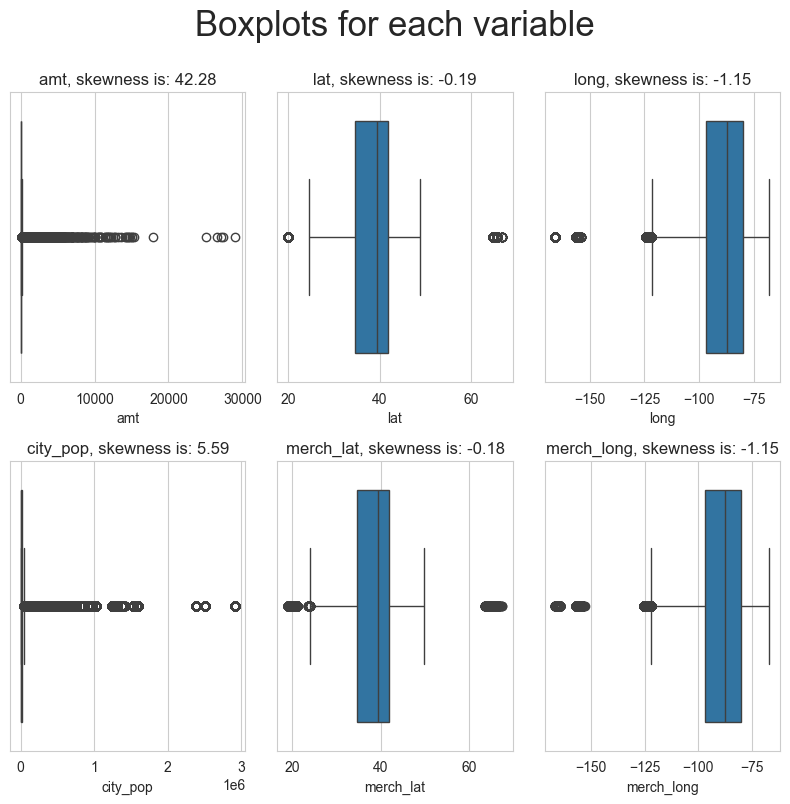

In [31]:
# checking boxplots
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(8,8))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=processed_df, columns_list=boxplot_columns, rows=2, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

In [32]:
# Calculate unique category counts
age_counts = fraud_df['age'].value_counts().reset_index()
age_counts

,age,count
0,49,201
1,33,197
2,58,195
3,43,185
4,22,175
...,...,...
75,93,16
76,15,16
77,75,12
78,68,11


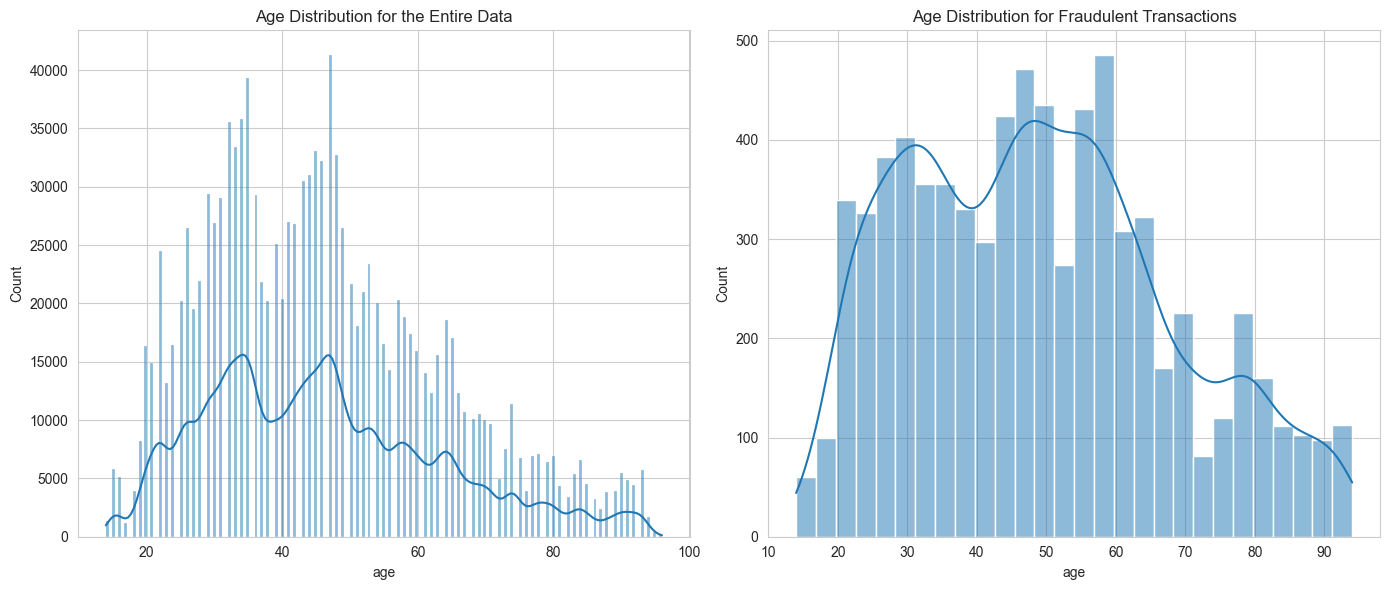

In [33]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Plot age distribution for the entire dataset
sns.histplot(data=processed_df, x='age', kde=True, ax=axes[0])
axes[0].set_title('Age Distribution for the Entire Data')

# Plot age distribution for fraudulent transactions
sns.histplot(data=fraud_df, x='age', kde=True, ax=axes[1])
axes[1].set_title('Age Distribution for Fraudulent Transactions')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

#### Observation:

The distribution on the right indicates that fraudulent transactions are most concentrated among individuals aged **30 to 50**, with notable peaks in the **early 30s** and **late 40s**. This suggests that individuals in these age brackets may be more susceptible to engaging in or being targeted by fraud. The increased prevalence in these specific age ranges highlights key segments that require closer monitoring in fraud detection efforts.

In [34]:
# Calculate unique city population counts
city_pop_counts = fraud_df['city_pop'].value_counts().reset_index()
city_pop_counts.head(20)

,city_pop,count
0,2906700,39
1,276002,29
2,190178,29
3,302,29
4,413574,27
5,1263321,27
6,277,27
7,163415,27
8,673342,26
9,471,26


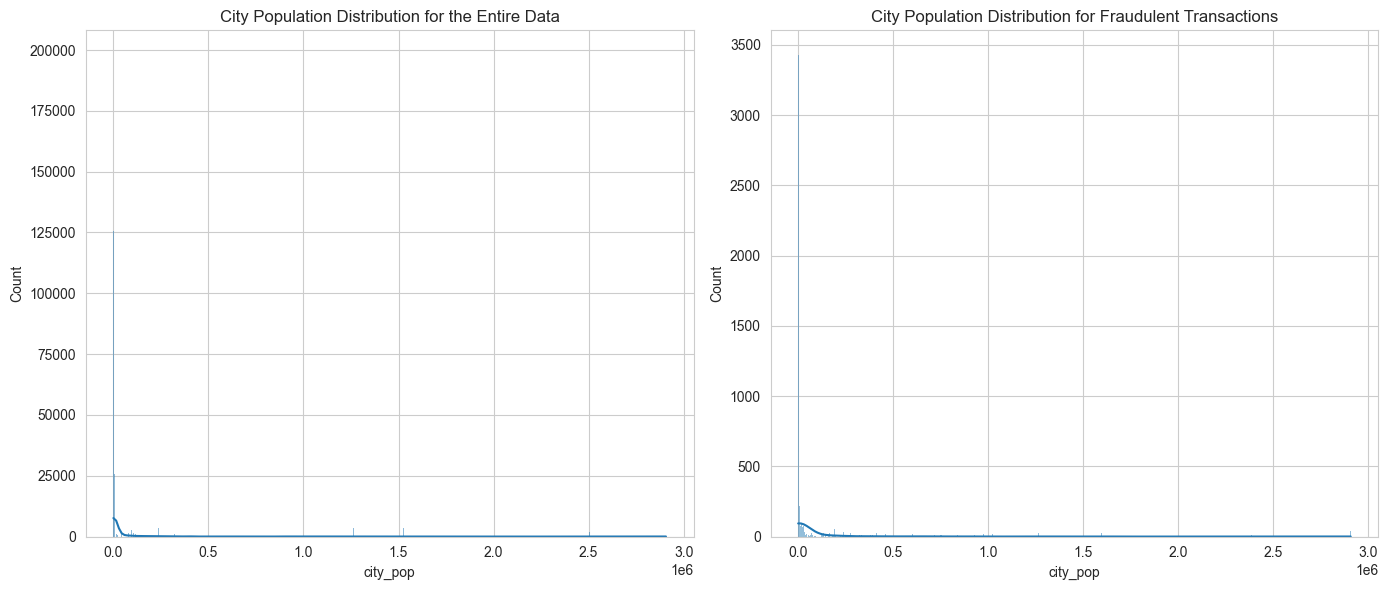

In [32]:
# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Plot age distribution for the entire dataset
sns.histplot(data=processed_df, x='city_pop', kde=True, ax=axes[0])
axes[0].set_title('City Population Distribution for the Entire Data')

# Plot age distribution for fraudulent transactions
sns.histplot(data=fraud_df, x='city_pop', kde=True, ax=axes[1])
axes[1].set_title('City Population Distribution for Fraudulent Transactions')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

### Observation

The data suggests that fraudulent transactions are not limited to large cities but are also present in smaller populations. The highest count of fraud cases (39) is observed in a city with a population of 2,906,700, indicating that larger populations might see more fraud activity due to the sheer volume of transactions. However, there are also multiple instances of fraud in cities with populations as low as 277, 302, and 365, each with 24 to 27 cases. This indicates that fraud is a widespread issue, affecting both large metropolitan areas and smaller communities. Therefore, fraud detection efforts should consider diverse city sizes, as it is not exclusively a big-city phenomenon.

## Separate features and target variables

In [35]:
features = [
    'category', 
    'amt', 
    'age', 
    'gender',
    'job',
    'city',
    'state',
    'zip',
    'city_pop',
    'lat', 
    'long',
    'merchant',
    'merch_lat', 
    'merch_long',
]

train_df = processed_df[features].copy()

train_df

,category,amt,age,gender,job,city,state,zip,city_pop,lat,long,merchant,merch_lat,merch_long
0,misc_net,4.97,31,F,"Psychologist, counselling",Moravian Falls,NC,28654,3495,36.0788,-81.1781,"fraud_Rippin, Kub and Mann",36.011293,-82.048315
1,grocery_pos,107.23,41,F,Special educational needs teacher,Orient,WA,99160,149,48.8878,-118.2105,"fraud_Heller, Gutmann and Zieme",49.159047,-118.186462
2,entertainment,220.11,57,M,Nature conservation officer,Malad City,ID,83252,4154,42.1808,-112.2620,fraud_Lind-Buckridge,43.150704,-112.154481
3,gas_transport,45.00,52,M,Patent attorney,Boulder,MT,59632,1939,46.2306,-112.1138,"fraud_Kutch, Hermiston and Farrell",47.034331,-112.561071
4,misc_pos,41.96,33,M,Dance movement psychotherapist,Doe Hill,VA,24433,99,38.4207,-79.4629,fraud_Keeling-Crist,38.674999,-78.632459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,entertainment,15.56,59,M,Geoscientist,Hatch,UT,84735,258,37.7175,-112.4777,fraud_Reichel Inc,36.841266,-111.690765
1296671,food_dining,51.70,41,M,"Production assistant, television",Tuscarora,MD,21790,100,39.2667,-77.5101,fraud_Abernathy and Sons,38.906881,-78.246528
1296672,food_dining,105.93,53,M,Naval architect,High Rolls Mountain Park,NM,88325,899,32.9396,-105.8189,fraud_Stiedemann Ltd,33.619513,-105.130529
1296673,food_dining,74.90,40,M,Volunteer coordinator,Manderson,SD,57756,1126,43.3526,-102.5411,"fraud_Reinger, Weissnat and Strosin",42.788940,-103.241160


In [36]:
target = processed_df['is_fraud']
target

0          0
1          0
2          0
3          0
4          0
          ..
1296670    0
1296671    0
1296672    0
1296673    0
1296674    0
Name: is_fraud, Length: 1296675, dtype: int64

### 3. Apply Categorical Encoding

In [44]:
train_df = pd.get_dummies(train_df, columns=['category', 'gender', 'state', 'job', 'city', 'merchant'])

train_df

,amt,age,zip,city_pop,lat,long,merch_lat,merch_long,category_entertainment,category_food_dining,...,"merchant_fraud_Yost, Schamberger and Windler",merchant_fraud_Yost-Rogahn,merchant_fraud_Zboncak LLC,merchant_fraud_Zboncak Ltd,"merchant_fraud_Zboncak, Rowe and Murazik",merchant_fraud_Zemlak Group,"merchant_fraud_Zemlak, Tillman and Cremin",merchant_fraud_Ziemann-Waters,"merchant_fraud_Zieme, Bode and Dooley",merchant_fraud_Zulauf LLC
0,4.97,31,28654,3495,36.0788,-81.1781,36.011293,-82.048315,False,False,...,False,False,False,False,False,False,False,False,False,False
1,107.23,41,99160,149,48.8878,-118.2105,49.159047,-118.186462,False,False,...,False,False,False,False,False,False,False,False,False,False
2,220.11,57,83252,4154,42.1808,-112.2620,43.150704,-112.154481,True,False,...,False,False,False,False,False,False,False,False,False,False
3,45.00,52,59632,1939,46.2306,-112.1138,47.034331,-112.561071,False,False,...,False,False,False,False,False,False,False,False,False,False
4,41.96,33,24433,99,38.4207,-79.4629,38.674999,-78.632459,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,15.56,59,84735,258,37.7175,-112.4777,36.841266,-111.690765,True,False,...,False,False,False,False,False,False,False,False,False,False
1296671,51.70,41,21790,100,39.2667,-77.5101,38.906881,-78.246528,False,True,...,False,False,False,False,False,False,False,False,False,False
1296672,105.93,53,88325,899,32.9396,-105.8189,33.619513,-105.130529,False,True,...,False,False,False,False,False,False,False,False,False,False
1296673,74.90,40,57756,1126,43.3526,-102.5411,42.788940,-103.241160,False,True,...,False,False,False,False,False,False,False,False,False,False


### Split the dataset using Stratified

Stratified splitting ensures that when you divide the dataset into training and validation sets, the class distribution remains consistent across each split. This technique maintains the same percentage of each class as found in the original dataset, which is crucial for imbalanced datasets or smaller sample sizes.

Without stratified splitting, the dataset is typically divided randomly based on the target variable. This can lead to variations in class distribution across splits, potentially skewing model performance and evaluation. By preserving the class proportions, stratified splitting provides more representative training and validation sets, resulting in more reliable and accurate model assessments.

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df, target, stratify=target, test_size=0.2, random_state=42)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (1037340, 2156)
Shape of X_test: (259335, 2156)
Shape of y_train: (1037340,)
Shape of y_test: (259335,)


In [46]:
X_columns = X_train.columns
X_columns

Index(['amt', 'age', 'zip', 'city_pop', 'lat', 'long', 'merch_lat',
       'merch_long', 'category_entertainment', 'category_food_dining',
       ...
       'merchant_fraud_Yost, Schamberger and Windler',
       'merchant_fraud_Yost-Rogahn', 'merchant_fraud_Zboncak LLC',
       'merchant_fraud_Zboncak Ltd',
       'merchant_fraud_Zboncak, Rowe and Murazik',
       'merchant_fraud_Zemlak Group',
       'merchant_fraud_Zemlak, Tillman and Cremin',
       'merchant_fraud_Ziemann-Waters',
       'merchant_fraud_Zieme, Bode and Dooley', 'merchant_fraud_Zulauf LLC'],
      dtype='object', length=2156)

### 4. Scaling the dataset

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X_train: (1037340, 2156)
Shape of X_test: (259335, 2156)


## Training the model

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
lr_model = LogisticRegression(max_iter=150, random_state=42)

In [51]:
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=150, random_state=42)

## Prediction

In [52]:
lr_predictions = lr_model.predict(X_test)
lr_predictions

array([0, 0, 0, ..., 0, 0, 0])

## Evaluation

### A.Confusion matrix
All binary classifiers of scikit-learn use a fixed decision threshold of 0.5 to convert probability estimates (i.e. output of predict_proba) into class predictions. However, 0.5 is almost never the desired threshold for a given problem. [FixedThresholdClassifier](https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.FixedThresholdClassifier.html#sklearn.model_selection.FixedThresholdClassifier) allows wrapping any binary classifier and setting a custom decision threshold.

array([[257727,    107],
       [  1335,    166]])

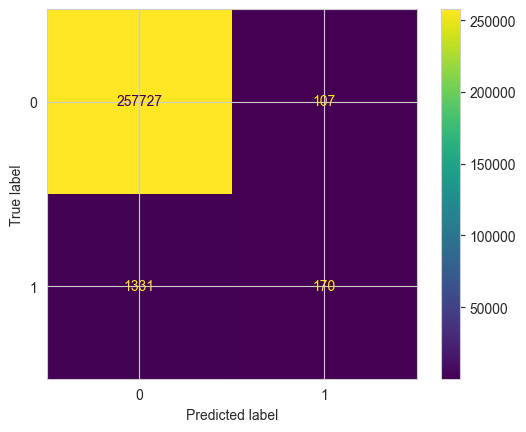

In [99]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

classifier_05 = LogisticRegression(C=1e6, random_state=0).fit(X_train, y_train)
ConfusionMatrixDisplay.from_estimator(classifier_05, X_test, y_test)

lr_confusion_score = confusion_matrix(y_test, lr_predictions)
lr_confusion_score

In [100]:
# Print the accuracy rate of the model
accuracy = accuracy_score(y_test, lr_predictions)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

# Print classification report with zero_division=1 to avoid warnings
report = classification_report(y_test, lr_predictions, zero_division=1)
print(f"\nClassification Report:\n{report}")

Logistic Regression Accuracy: 0.9944

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    257834
           1       0.61      0.11      0.19      1501

    accuracy                           0.99    259335
   macro avg       0.80      0.56      0.59    259335
weighted avg       0.99      0.99      0.99    259335



#### Outcome Explanation:

The logistic regression model correctly identifies fraudulent transaction with 61% correctness, but it can only identifies 11% of actual fraudulent transactions, which means that most fraudulent transactions are missed. This low recall is critical because, in fraud detection, catching as many fraudulent cases as possible is often more important.

### B. When is Precision more important over Recall?

Precision is more important than Recall when you would like to have less False Positives 
in trade off to have more False Negatives. Meaning, getting a False Positive is very costly, and a False Negative is not as much.

Imagine a zombie apocalypse. You would try to accept as many healthy people as you can into your safe zone, 
but you really dont want to mistakenly pass a zombie. The true positive is this case is a healthy person and false positive a zombie. It is more important to avoid zombies than accepting more healthy people. So you create a method that causes some of the healthy people mistakenly not to get into the safe zone, but this is the cost of not letting a zombie in.

## Compare different model performance

XGBClassifier Accuracy: 0.9940

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.47      0.28      0.35      1501

    accuracy                           0.99    259335
   macro avg       0.73      0.64      0.67    259335
weighted avg       0.99      0.99      0.99    259335

Model saved as XGBClassifier.pkl
Time taken for execution: 19.28 seconds
--------------------------------------------------



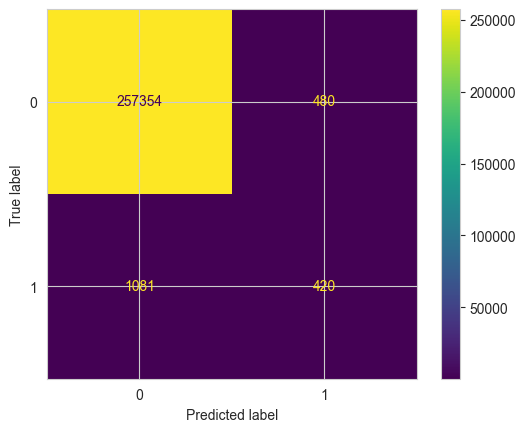

In [112]:
# With 2156 features, it took 19.28 seconds to execute

xgb_model = xgb.XGBClassifier(random_state=42)
evaluate_and_save_model(xgb_model, X_train, X_test, y_train, y_test)

RandomForestClassifier Accuracy: 0.9969

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.91      0.53      0.67      1501

    accuracy                           1.00    259335
   macro avg       0.95      0.76      0.83    259335
weighted avg       1.00      1.00      1.00    259335

Model saved as RandomForestClassifier.pkl
Time taken for execution: 740.14 seconds
--------------------------------------------------



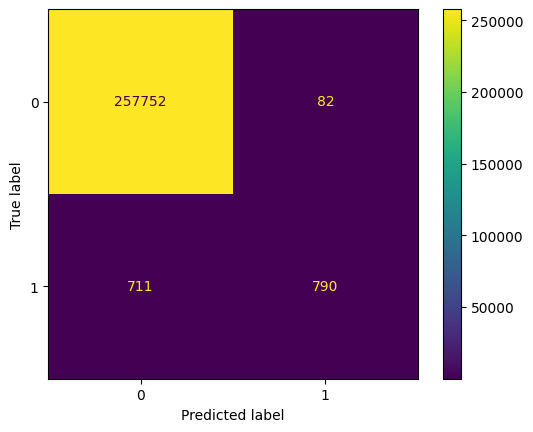

In [51]:
# With 2156 features, it took 767.41 seconds to execute

rfc_model = RandomForestClassifier(random_state=42)
evaluate_and_save_model(rfc_model, X_train, X_test, y_train, y_test)

DecisionTreeClassifier Accuracy: 0.9934

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.45      0.63      0.52      1501

    accuracy                           0.99    259335
   macro avg       0.72      0.81      0.76    259335
weighted avg       0.99      0.99      0.99    259335

Model saved as DecisionTreeClassifier.pkl
Time taken for execution: 216.69 seconds
--------------------------------------------------



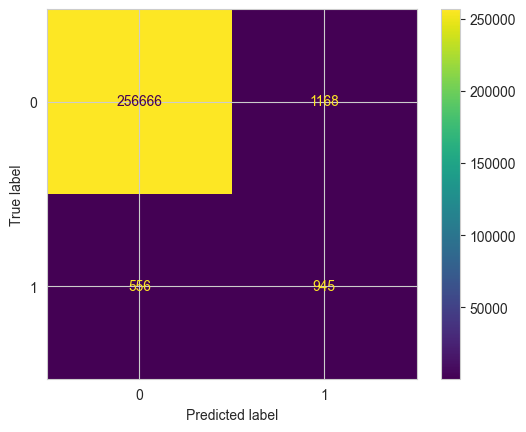

In [116]:
# With 2156 features, it took 216.69 seconds to execute

dtc_model = DecisionTreeClassifier(random_state=42)
evaluate_and_save_model(dtc_model, X_train, X_test, y_train, y_test)

GaussianNB Accuracy: 0.9948

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    257834
           1       1.00      0.10      0.18      1501

    accuracy                           0.99    259335
   macro avg       1.00      0.55      0.59    259335
weighted avg       0.99      0.99      0.99    259335

Model saved as GaussianNB.pkl
Time taken for execution: 42.27 seconds
--------------------------------------------------



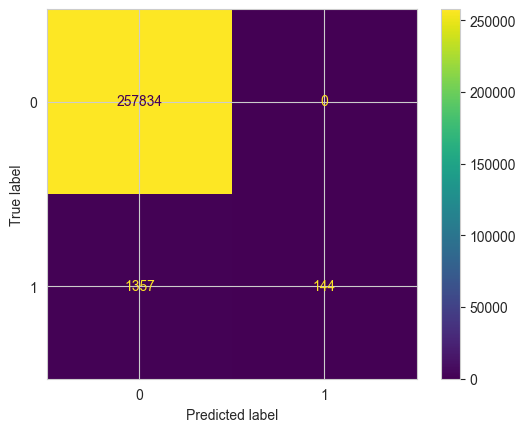

In [114]:
# With 2156 features, it took 49.21 seconds to execute

gnb_model = GaussianNB()
evaluate_and_save_model(gnb_model, X_train, X_test, y_train, y_test)

In [105]:
# Takes a lot of time. SVC model is useful for anomaly detection.

# svc_model = SVC(probability=True, class_weight='balanced')
# evaluate_and_save_model(svc_model, X_train, X_test, y_train, y_test)

In [106]:
# Takes a lot of time. KNearest neighbors is useful for anomaly detection

# knc_model = KNeighborsClassifier()
# evaluate_and_save_model(knc_model, X_train, X_test, y_train, y_test)

### Recall as the preferred metric

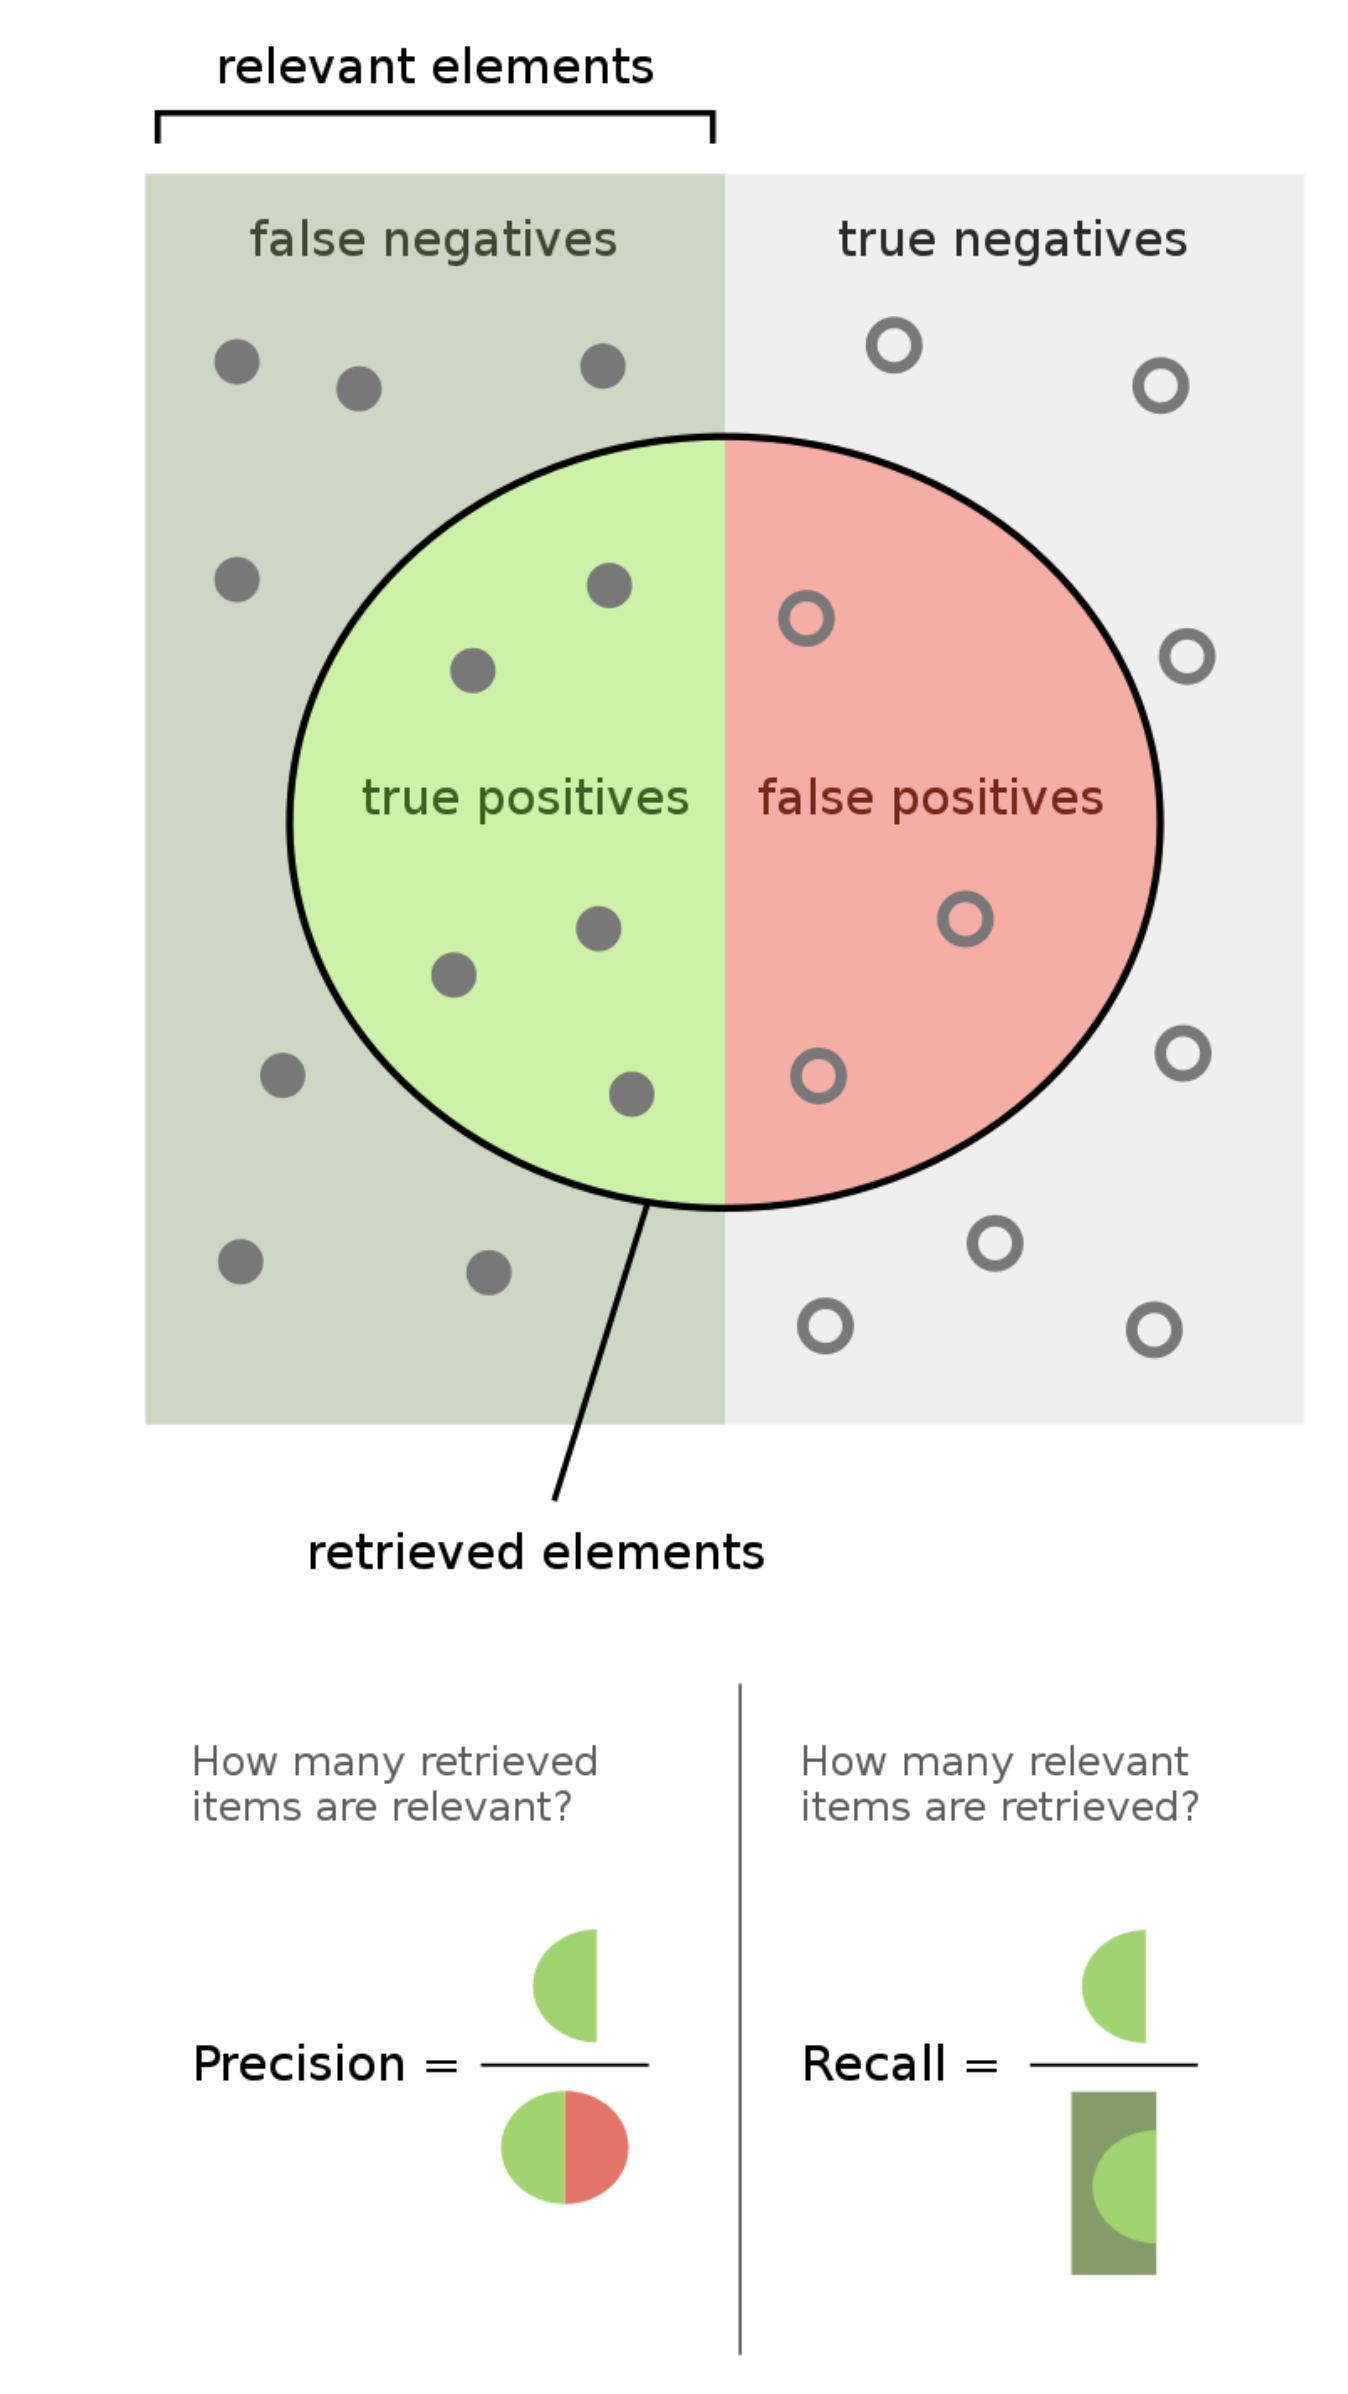

Recall: The ability of a model to find all the relevant cases within a data set. The number of true positives divided by the number of true positives plus the number of false negatives.

In most high-risk detection cases (like cancer), recall is a more important evaluation metric than precision.

In the case of credit card fraud detection, we want to avoid false negatives as much as possible. Fraud transactions cost us a lot and thus we want to take appropriate measures to prevent them. A false negative case means that a fraud-positive transaction is assessed to genuine transaction, which is detrimental. In this use case, false positives (a genuine transaction as fraud-positive) are not as important as preventing a fraud.

### Feature importance

Size of feature importances: 2156, Size of feature names: 2156


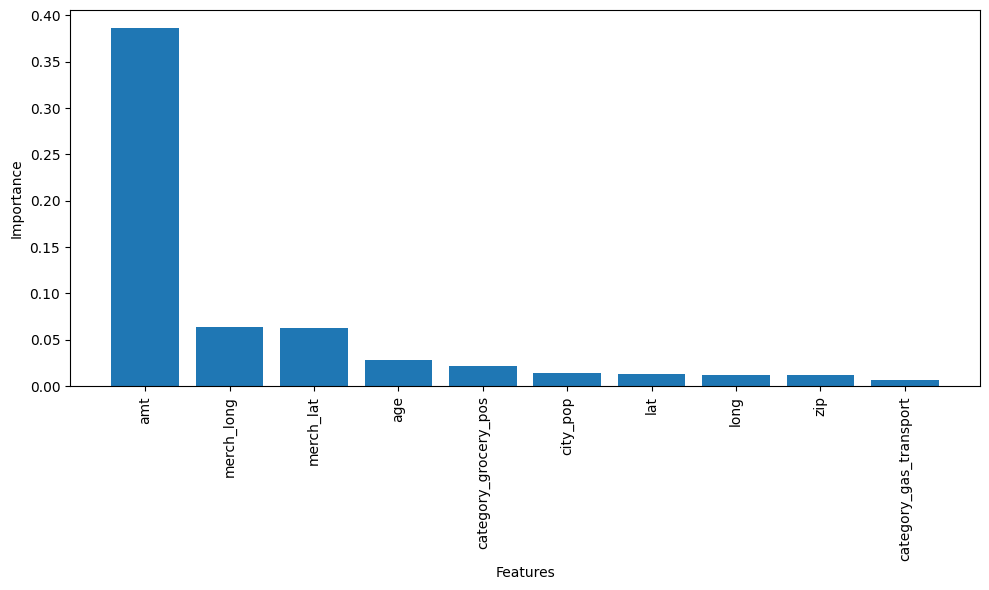

In [55]:
feature_importances = rfc_model.feature_importances_
feature_names = train_df.columns

print(f'Size of feature importances: {len(feature_importances)}, Size of feature names: {len(feature_names)}')

feature_importances_df = pd.DataFrame({
    'features': feature_names,
    'importance': feature_importances
})

# Sort the results
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importances_df['features'][:10], feature_importances_df['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

## Performance Improvement

### A.1. Feature Selection

* Minimize jobs to 5 bins
* Remove city, city_pop, merchant

In [53]:
modified_df = processed_df.copy()
modified_df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,is_fraud,trans_year,dob_year,age,ageGroup,price_ratio_to_median,category_codes,state_codes,ageGroup_codes,gender_codes
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0,2019,1988,31,Early,0.104588,8,27,0,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,0,2019,1978,41,MiddleAge,2.256524,4,47,1,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,0,2019,1962,57,Senior,4.631944,0,13,2,1
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,0,2019,1967,52,Senior,0.946970,2,26,2,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,0,2019,1986,33,MiddleAge,0.882997,9,45,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,...,0,2020,1961,59,Senior,0.327441,0,44,2,1
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,...,0,2020,1979,41,MiddleAge,1.087963,1,20,1,1
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,...,0,2020,1967,53,Senior,2.229167,1,32,2,1
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,...,0,2020,1980,40,MiddleAge,1.576178,1,41,1,1


### K-Means for job clustering

In [54]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.cluster import KMeans

# job_titles = ['Technical and Engineering Professional',
#               'Healthcare, Education, and Research Professional',
#               'Public Service, Administration, and Community Development Professional',
#               'Creative, Media, and Communication Specialist',
#               'Legal, Finance, and Compliance Expert'
#              ]

# # Get the unique jobs from the DataFrame
# unique_jobs = list(modified_df['job'].unique())

# # Combine job titles and unique jobs for vectorization
# combined_jobs = job_titles + unique_jobs

# # Vectorize job titles using TF-IDF
# vectorizer = TfidfVectorizer(stop_words='english')
# vectorized_df = vectorizer.fit_transform(combined_jobs)

# # Apply KMeans clustering
# num_clusters = len(job_titles)
# kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
# kmeans.fit(vectorized_df)

# # Create a mapping of unique jobs to cluster labels
# job_cluster_mapping = {job: job_titles[label] for job, label in zip(unique_jobs, kmeans.labels_[len(job_titles):])}

# # Map clusters to the original DataFrame
# modified_df['job_category'] = modified_df['job'].map(job_cluster_mapping)

# # Drop job column
# if 'job' in modified_df.columns:
#     modified_df = modified_df.drop(columns=['job'])
    
# modified_df

### B. Feature Engineering
* Age grouping
* Distance from home
* Ratio_to_median_purchase price

### Feature Engineering: Euclidean distance from home

In [84]:
# Calculate Euclidean distance
# modified_df['euclidean_distance'] = np.sqrt(
#     (modified_df['lat'] - modified_df['merch_lat'])**2 + (modified_df['long'] - modified_df['merch_long'])**2
# )
# modified_df

### One-hot Encoding (More efficient than get_dummy encoding)


One-hot encoding is a technique used to convert categorical data into a numerical format that machine learning models can understand. It transforms each category into a binary vector.

#### To fix train-test skew in categorical data:

Categories in Training but not in Testing: Categorical types save all categories seen during training. Missing categories in testing are filled with NaN.

Categories in Testing but not in Training: One-hot encoding with categorical types removes extra columns in the test set that aren't in the training set.

Using categorical types ensures consistent column alignment across training and testing, unlike pd.get_dummies() on string columns, which can lead to mismatches.

In [60]:
cat_cols = ['category', 'state', 'ageGroup', 'gender']
mappings, processed_df, test_processed_df = encode_categories(processed_df, test_processed_df, cat_cols)

{'ageGroup': {0: 'Early', 1: 'MiddleAge', 2: 'Senior', 3: 'Elderly'},
 'category': {0: 'entertainment',
              1: 'food_dining',
              2: 'gas_transport',
              3: 'grocery_net',
              4: 'grocery_pos',
              5: 'health_fitness',
              6: 'home',
              7: 'kids_pets',
              8: 'misc_net',
              9: 'misc_pos',
              10: 'personal_care',
              11: 'shopping_net',
              12: 'shopping_pos',
              13: 'travel'},
 'gender': {0: 'F', 1: 'M'},
 'state': {0: 'AK',
           1: 'AL',
           2: 'AR',
           3: 'AZ',
           4: 'CA',
           5: 'CO',
           6: 'CT',
           7: 'DC',
           8: 'DE',
           9: 'FL',
           10: 'GA',
           11: 'HI',
           12: 'IA',
           13: 'ID',
           14: 'IL',
           15: 'IN',
           16: 'KS',
           17: 'KY',
           18: 'LA',
           19: 'MA',
           20: 'MD',
           21: 'ME',
     

## Heatmap for fraud set

In [75]:
processed_df

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,is_fraud,trans_year,dob_year,age,ageGroup,price_ratio_to_median,category_codes,state_codes,ageGroup_codes,gender_codes
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0,2019,1988,31,Early,0.104588,8,27,0,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,0,2019,1978,41,MiddleAge,2.256524,4,47,1,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,0,2019,1962,57,Senior,4.631944,0,13,2,1
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,0,2019,1967,52,Senior,0.946970,2,26,2,1
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,0,2019,1986,33,MiddleAge,0.882997,9,45,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,...,0,2020,1961,59,Senior,0.327441,0,44,2,1
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,...,0,2020,1979,41,MiddleAge,1.087963,1,20,1,1
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,...,0,2020,1967,53,Senior,2.229167,1,32,2,1
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,...,0,2020,1980,40,MiddleAge,1.576178,1,41,1,1


In [78]:
mod_fraud_df = processed_df.query('is_fraud == 1')
mod_fraud_df = mod_fraud_df[['amt', 'age', 'zip', 'state_codes', 'gender_codes', 'category_codes', 'ageGroup_codes', 'price_ratio_to_median']]

<Axes: >

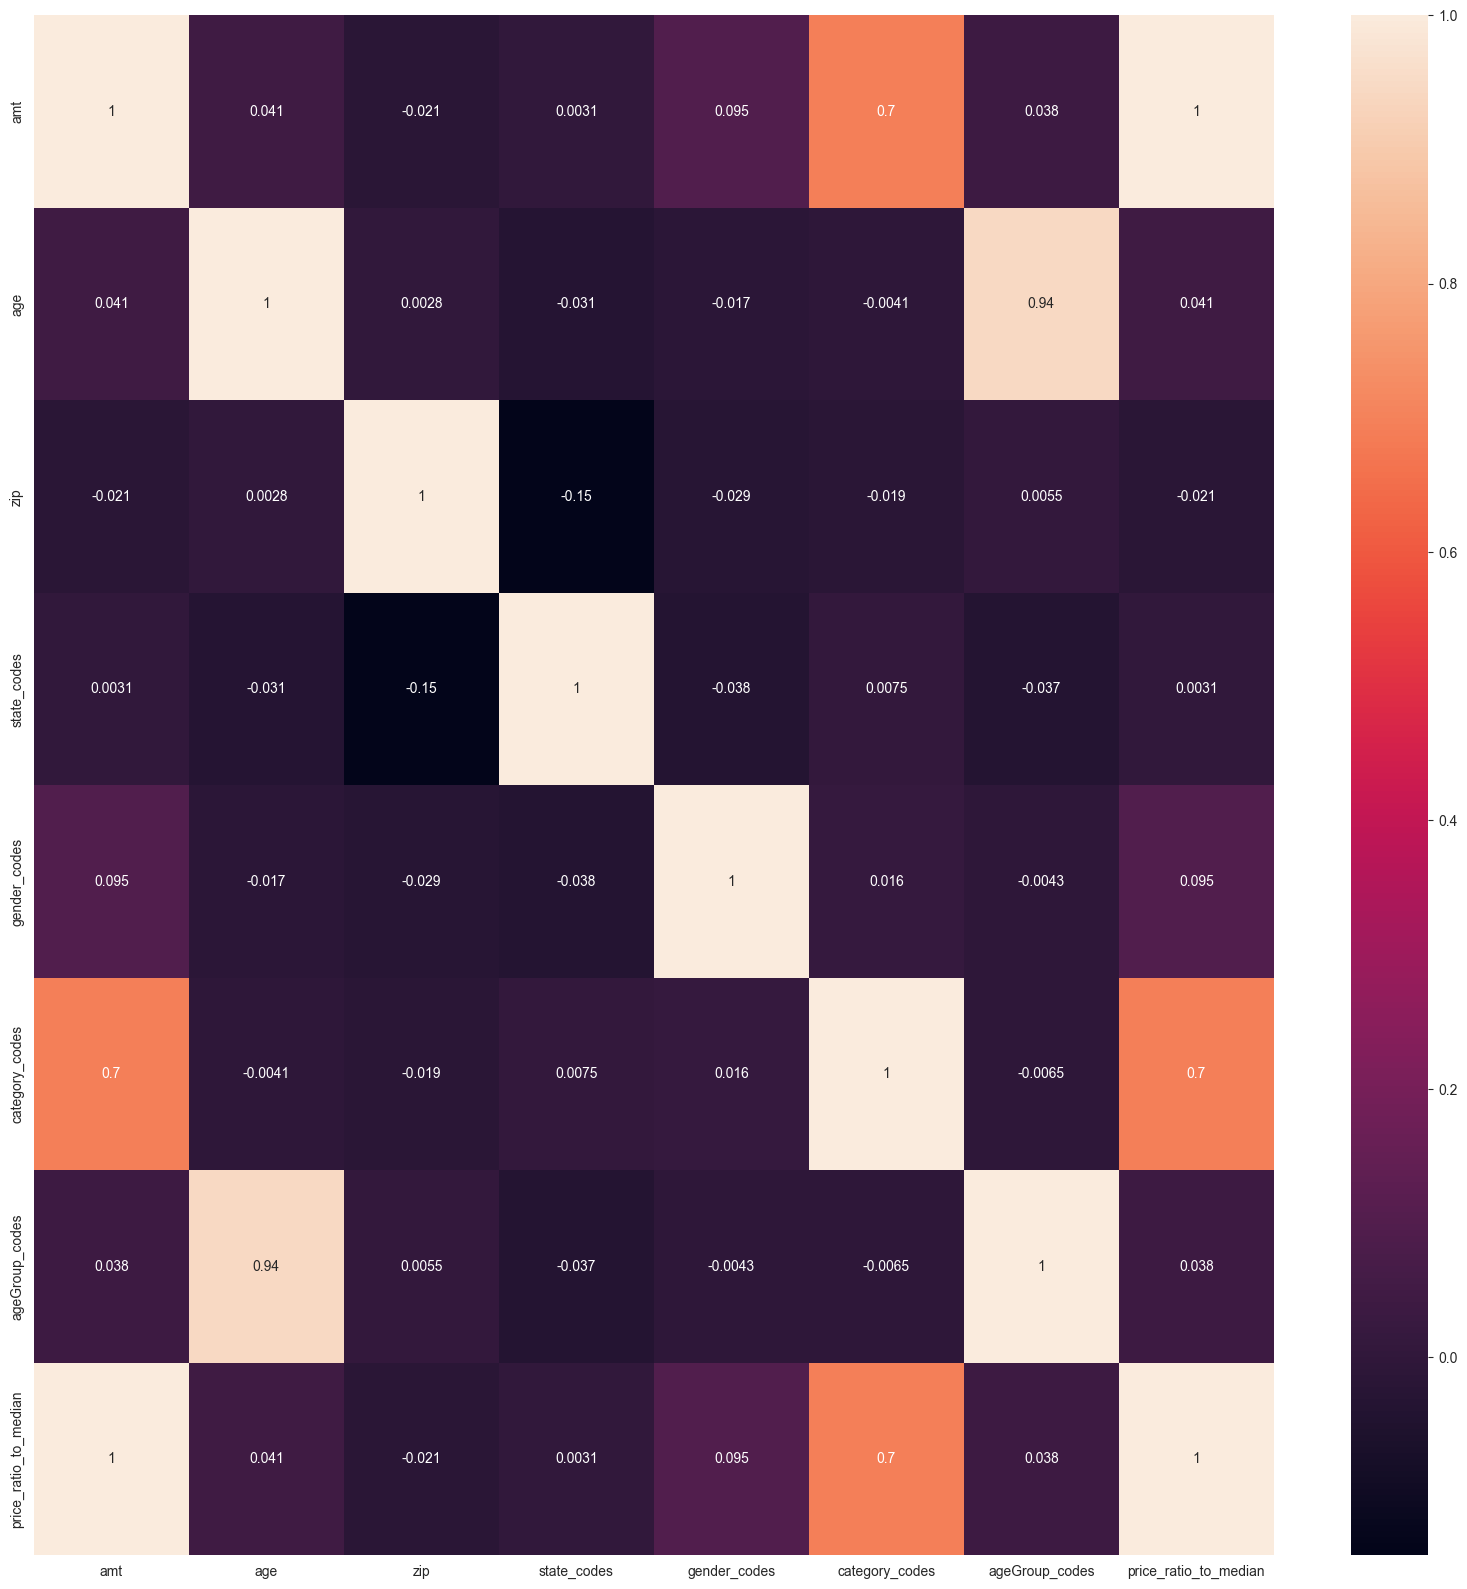

In [79]:
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(mod_fraud_df.corr(), annot = True)

In [90]:
features = [
    'amt', 
    'age', 
    'price_ratio_to_median',
    'category_codes',
    'state_codes',
    'ageGroup_codes',
    'gender_codes', 
]

mod_train_df = processed_df[features].copy()
target = processed_df['is_fraud']

mod_train_df

,amt,age,price_ratio_to_median,category_codes,state_codes,ageGroup_codes,gender_codes
0,4.97,31,0.104588,8,27,0,0
1,107.23,41,2.256524,4,47,1,0
2,220.11,57,4.631944,0,13,2,1
3,45.00,52,0.946970,2,26,2,1
4,41.96,33,0.882997,9,45,1,1
...,...,...,...,...,...,...,...
1296670,15.56,59,0.327441,0,44,2,1
1296671,51.70,41,1.087963,1,20,1,1
1296672,105.93,53,2.229167,1,32,2,1
1296673,74.90,40,1.576178,1,41,1,1


In [96]:
mod_X_train, mod_X_test, mod_y_train, mod_y_test = train_test_split(mod_train_df, target, test_size=0.2, random_state=42)
print(mod_X_train.size, mod_X_test.size)

7261380 1815345


## Retrain models

XGBClassifier Accuracy: 0.9972

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.82      0.66      0.73      1520

    accuracy                           1.00    259335
   macro avg       0.91      0.83      0.87    259335
weighted avg       1.00      1.00      1.00    259335

Model saved as model_fraud/XGBClassifier-featured.pkl
Time taken for execution: 1.03 seconds
--------------------------------------------------



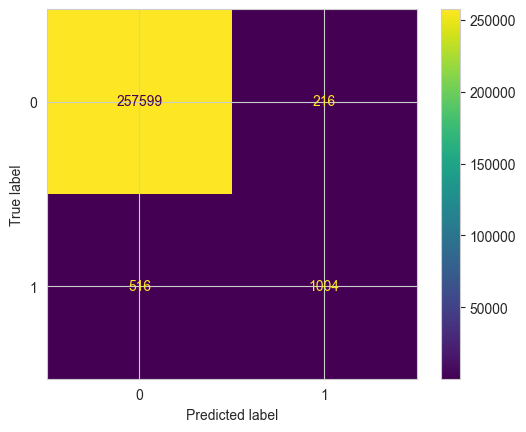

In [ ]:
# With 7 features, it took 1.05 seconds to execute

improved_xgb_model = xgb.XGBClassifier(random_state=42)
evaluate_and_save_model(improved_xgb_model, mod_X_train, mod_X_test, mod_y_train, mod_y_test, suffix='-featured')

RandomForestClassifier Accuracy: 0.9974

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.83      0.68      0.75      1520

    accuracy                           1.00    259335
   macro avg       0.92      0.84      0.88    259335
weighted avg       1.00      1.00      1.00    259335

Model saved as model_fraud/RandomForestClassifier-featured.pkl
Time taken for execution: 56.28 seconds
--------------------------------------------------



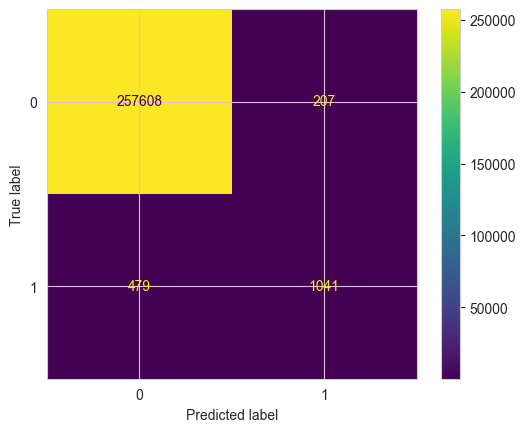

In [ ]:
# With 7 features, it took 56.28 seconds to execute

improved_rfc_model = RandomForestClassifier(random_state=42)
evaluate_and_save_model(improved_rfc_model, mod_X_train, mod_X_test, mod_y_train, mod_y_test, suffix='-featured')

DecisionTreeClassifier Accuracy: 0.9959

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257815
           1       0.64      0.67      0.66      1520

    accuracy                           1.00    259335
   macro avg       0.82      0.84      0.83    259335
weighted avg       1.00      1.00      1.00    259335

Model saved as model_fraud/DecisionTreeClassifier-featured.pkl
Time taken for execution: 2.46 seconds
--------------------------------------------------



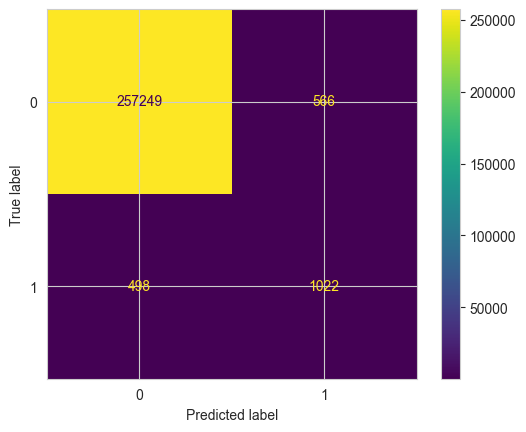

In [ ]:
# With 7 features, it took 2.46 seconds to execute

improved_dtc_model = DecisionTreeClassifier(random_state=42)
evaluate_and_save_model(improved_dtc_model, mod_X_train, mod_X_test, mod_y_train, mod_y_test, suffix='-featured')

GaussianNB Accuracy: 0.9861

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    257815
           1       0.21      0.50      0.30      1520

    accuracy                           0.99    259335
   macro avg       0.60      0.74      0.64    259335
weighted avg       0.99      0.99      0.99    259335

Model saved as model_fraud/GaussianNB-featured.pkl
Time taken for execution: 0.15 seconds
--------------------------------------------------



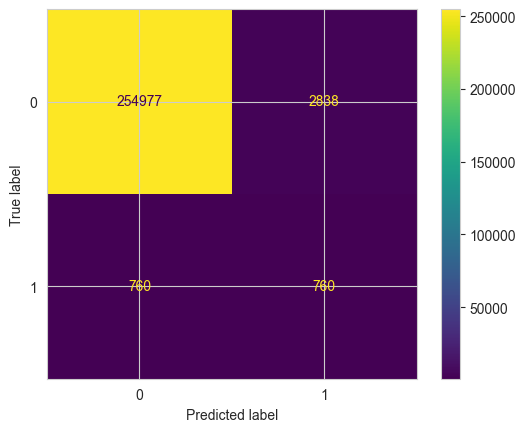

In [ ]:
# With 11 features, it took 0.15 seconds to execute

improved_gnb_model = GaussianNB()
evaluate_and_save_model(improved_gnb_model, mod_X_train, mod_X_test, mod_y_train, mod_y_test, suffix='-featured')

In [ ]:
# Takes a lot of time. SVC model is useful for anomaly detection.

# improved_svc_model = SVC(probability=True, class_weight='balanced')
# evaluate_and_save_model(improved_svc_model, mod_X_train, mod_X_test, mod_y_train, mod_y_test, suffix='-featured')

In [ ]:
# Takes a lot of time. KNC model is useful for anomaly detection.

# improved_knc_model = KNeighborsClassifier()
# evaluate_and_save_model(improved_knc_model, mod_X_train, mod_X_test, mod_y_train, mod_y_test, suffix='-featured')

#### BEST MODEL: RandomForestClassifier

Size of feature importances: 7, Size of feature names: 7


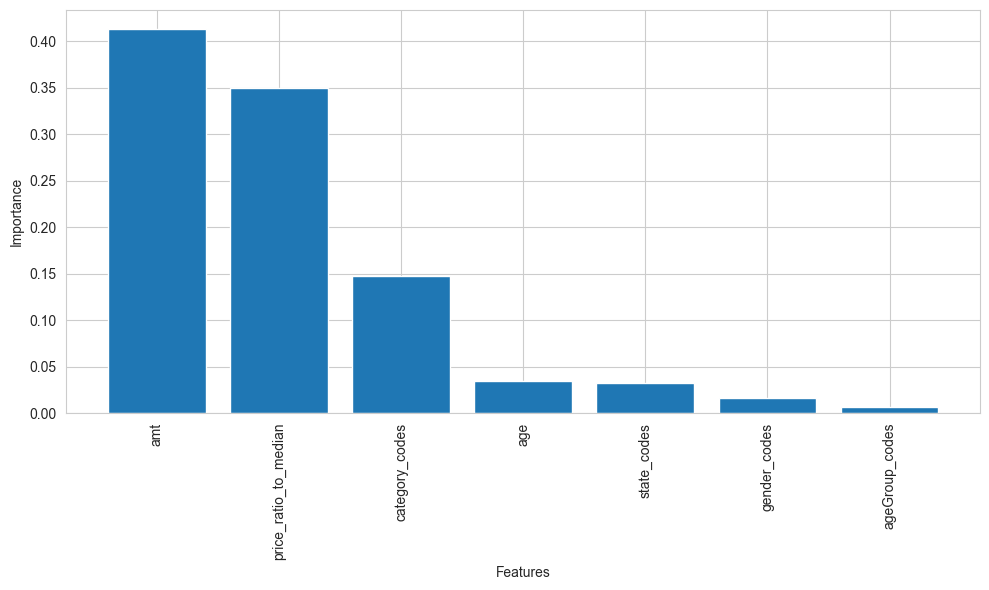

,features,importance
0,amt,0.412882
2,price_ratio_to_median,0.349721
3,category_codes,0.147299
1,age,0.034644
4,state_codes,0.032637
6,gender_codes,0.016244
5,ageGroup_codes,0.006573


In [105]:
feature_importances = improved_rfc_model.feature_importances_
feature_names = mod_train_df.columns

print(f'Size of feature importances: {len(feature_importances)}, Size of feature names: {len(feature_names)}')

feature_importances_df = pd.DataFrame({
    'features': feature_names,
    'importance': feature_importances
})

# Sort the results
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importances_df['features'][:10], feature_importances_df['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

feature_importances_df

### B. Synthetic Minority Over-sampling Technique (SMOTE)

SMOTE (Synthetic Minority Oversampling Technique) is a technique used to address class imbalance by generating synthetic data for the minority class. It works by identifying similar instances within the minority class in the feature space and creating new samples along the lines connecting these instances. For example, in a dataset with fraudulent transactions (minority class), SMOTE generates new synthetic fraud cases to improve the model's ability to learn and recognize patterns associated with fraud.

By creating realistic synthetic samples, SMOTE enhances the representation of the minority class by focusing on the most informative features. This process continues until the minority class is more balanced with the majority class, leading to improved model performance and more reliable predictions across both classes.

In [101]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(mod_X_train, mod_y_train)

XGBClassifier Accuracy: 0.9779

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    257815
           1       0.20      0.92      0.33      1520

    accuracy                           0.98    259335
   macro avg       0.60      0.95      0.66    259335
weighted avg       0.99      0.98      0.98    259335

Model saved as model_fraud/XGBClassifier-SMOTE.pkl
Time taken for execution: 2.07 seconds
--------------------------------------------------



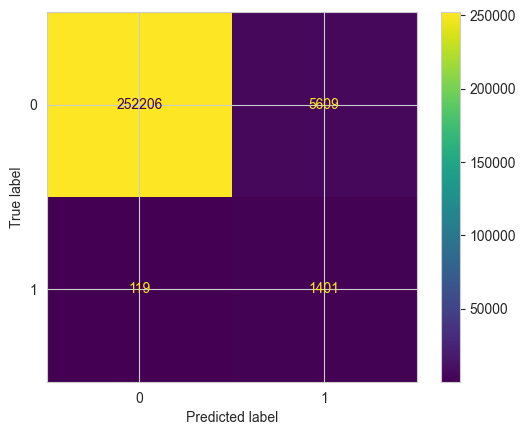

In [ ]:
# Took 2.07 seconds
evaluate_and_save_model(improved_xgb_model, X_resampled, mod_X_test, y_resampled, mod_y_test, suffix='-SMOTE')

RandomForestClassifier Accuracy: 0.9916

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    257815
           1       0.39      0.81      0.53      1520

    accuracy                           0.99    259335
   macro avg       0.70      0.90      0.76    259335
weighted avg       1.00      0.99      0.99    259335

Model saved as model_fraud/RandomForestClassifier-SMOTE.pkl
Time taken for execution: 171.03 seconds
--------------------------------------------------



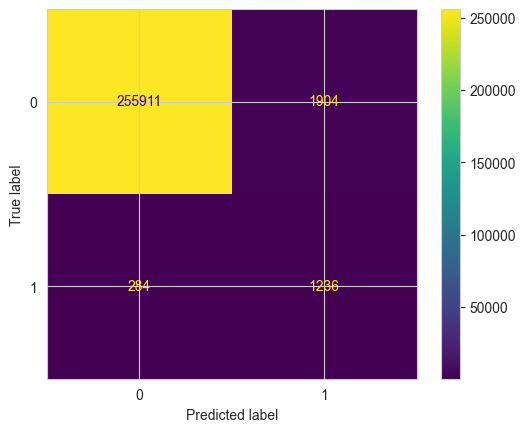

In [ ]:
# Took 171.03 seconds
evaluate_and_save_model(improved_rfc_model, X_resampled, mod_X_test, y_resampled, mod_y_test, suffix='-SMOTE')

DecisionTreeClassifier Accuracy: 0.9913

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    257815
           1       0.38      0.76      0.51      1520

    accuracy                           0.99    259335
   macro avg       0.69      0.88      0.75    259335
weighted avg       0.99      0.99      0.99    259335

Model saved as model_fraud/DecisionTreeClassifier-SMOTE.pkl
Time taken for execution: 7.91 seconds
--------------------------------------------------



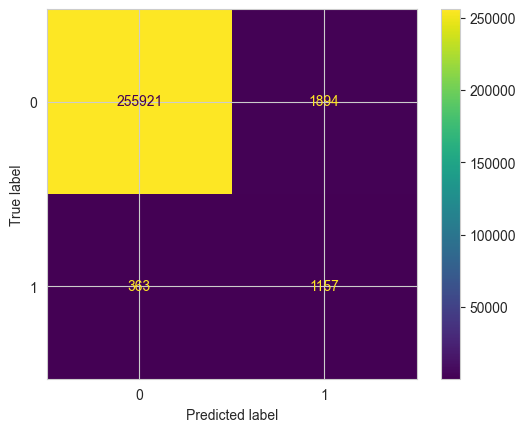

In [ ]:
# Took 7.91 seconds
evaluate_and_save_model(improved_dtc_model, X_resampled, mod_X_test, y_resampled, mod_y_test, suffix='-SMOTE')

DecisionTreeClassifier Accuracy: 0.9913

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    257815
           1       0.38      0.76      0.51      1520

    accuracy                           0.99    259335
   macro avg       0.69      0.88      0.75    259335
weighted avg       0.99      0.99      0.99    259335

Model saved as DecisionTreeClassifier-SMOTE.pkl
Time taken for execution: 7.55 seconds
--------------------------------------------------



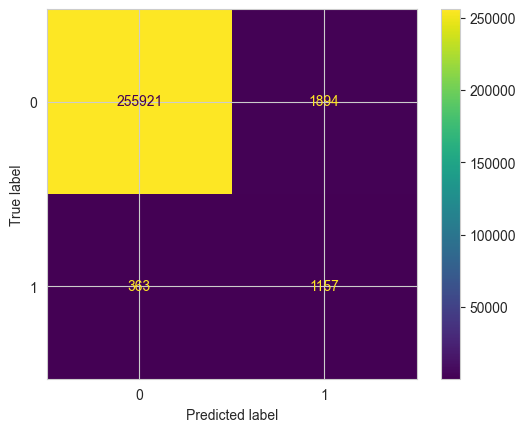

In [ ]:
# Took  7.55 seconds
evaluate_and_save_model(improved_gnb_model, X_resampled, mod_X_test, y_resampled, mod_y_test, suffix='-SMOTE')

### C. Ensembling

VotingClassifier Accuracy: 0.9922

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    257815
           1       0.42      0.85      0.56      1520

    accuracy                           0.99    259335
   macro avg       0.71      0.92      0.78    259335
weighted avg       1.00      0.99      0.99    259335

Model saved as -voting/VotingClassifier.pkl
Time taken for execution: 173.06 seconds
--------------------------------------------------



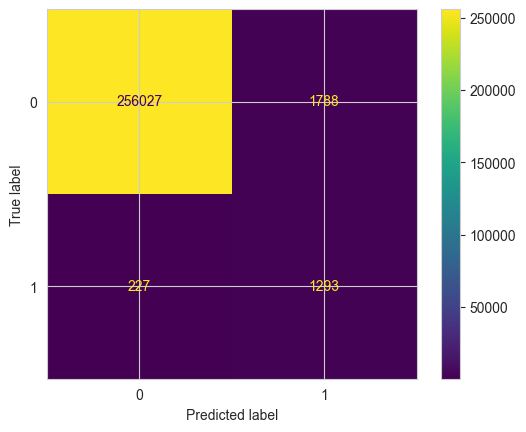

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('xgboost', xgb.XGBClassifier(random_state=42)), 
        ('rf', RandomForestClassifier(random_state=42)),
        ('dtc', DecisionTreeClassifier(random_state=42)),
        ('gnb', GaussianNB()),
    ], voting = 'soft')

evaluate_and_save_model(voting_clf, X_resampled, mod_X_test, y_resampled, mod_y_test, suffix='-voting')

### B. Hyperparameter Tuning Using GridSearchCV

Hyperparameter tuning is the process of tuning the parameters present as the tuples while we build machine learning models. These parameters are defined by us. Machine learning algorithms never learn these parameters. These can be tuned in different step.

GridSearchCV is a technique for finding the optimal hyperparameter values from a given set of parameters in a grid. It's essentially a cross-validation technique. The model as well as the parameters must be entered. After extracting the best parameter values, predictions are made.

The “best” parameters that GridSearchCV identifies are technically the best that could be produced, but only by the parameters that you included in your parameter grid.

In [110]:
from sklearn.model_selection import StratifiedKFold

#We are going to ensure that we have the same splits of the data every time. 
#We can ensure this by creating a KFold object, kf, and passing cv=kf instead of the more common cv=5.

kf = StratifiedKFold(n_splits=5, shuffle=False)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 80],
    'max_depth': [4, 6, 10],
    'random_state': [13]
}

grid_rf = GridSearchCV(improved_rfc_model, param_grid=params, cv=kf, 
                          scoring='recall').fit(X_train, y_train)

print('Best parameters:', grid_rf.best_params_)
print('Best score:', grid_rf.best_score_)

### D. Using Tomek Links

In [416]:
### Using GridSearchCV

## Prepare dataset for Strealit

In [ ]:
# Export to a .csv file
# filename = 'test_processed.csv'
# test_processed_df.to_csv(filename, index=False)

# chunk_and_save(filename)

Use these paths to access the test_processed.csv files

"https://drive.google.com/file/d/1YX8nAkPTJQsWwzntSsongStMx90aqtt6/view?usp=sharing",
"https://drive.google.com/file/d/1wMtT4tTN-FeLIurMKnyakpQMbaE6sNU6/view?usp=sharing",
"https://drive.google.com/file/d/1m8P04W0SGOHNQqagemsO7yPDobQph89w/view?usp=sharing",
"https://drive.google.com/file/d/1dhusoHv5-sqWeqz635JPxMkWRzAbSfqK/view?usp=sharing",
"https://drive.google.com/file/d/10sfMBCS8Eet-VJoZqHEr3EVQq24boFbk/view?usp=sharing",
"https://drive.google.com/file/d/1twtyCBtyffRvFf6-JbXNCEcCKo-fPrOi/view?usp=sharing"
